In [152]:
import xarray as xr
import numpy as np
import pandas as pd
import scipy as sp
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from scipy import signal, stats

In [3]:
land = xr.open_dataset("./../co2_temp_data/temp/CRUTEM.4.6.0.0.anomalies.nc")
ocean = xr.open_dataset("./../co2_temp_data/temp/HadSST.3.1.1.0.median.nc")

In [26]:
ocean

<xarray.Dataset>
Dimensions:       (latitude: 36, longitude: 72, nv: 2, time: 2039)
Coordinates:
  * time          (time) datetime64[ns] 1850-01-16T11:59:59.505615234 ... 2019-11-16
  * latitude      (latitude) float32 87.5 82.5 77.5 72.5 ... -77.5 -82.5 -87.5
  * longitude     (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
Dimensions without coordinates: nv
Data variables:
    time_bnds     (time, nv) float32 ...
    field_status  (time) |S1 ...
    sst           (time, latitude, longitude) float32 ...
Attributes:
    Title:                      Monthly 5 degree version of HadSST.3.1.1.0 - ...
    source:                     HadSST.3.1.1.0
    reference:                  Kennedy J.J., Rayner, N.A., Smith, R.O., Saun...
    Conventions:                CF-1.0
    history:                    10/12/2019 converted to netcdf
    supplementary_information:  Updates and supplementary information are ava...
    ensemble_members:           100

In [19]:
land.temperature_anomaly.sel(time="2012-04")

<xarray.DataArray 'temperature_anomaly' (time: 1, latitude: 36, longitude: 72)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) datetime64[ns] 2012-04-16
Attributes:
    long_name:         temperature_anomaly
    units:             K
    reference_period:  [1961 1990]

In [68]:
def plot_land(data):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.contourf(land.longitude, land.latitude, data)
    
def plot_ocean(data):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.coastlines()
    ax.contourf(ocean.longitude, ocean.latitude, data)

In [69]:
ocean.sst.sel(time="1954-01").values.squeeze()

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

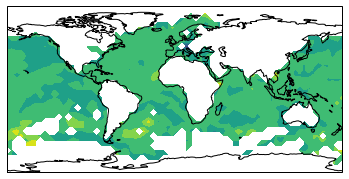

In [70]:
plot_ocean(ocean.sst.sel(time="2002-01").values.squeeze())

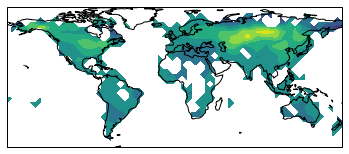

In [71]:
plot_land(land.temperature_anomaly.sel(time="2002-01").values.squeeze())

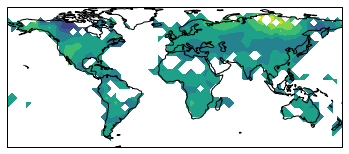

In [77]:
plot_land(land.temperature_anomaly.sel(time="1959-06").values.squeeze())

# Monthly global

In [98]:
monthly = pd.read_csv("./../co2_temp_data/temp/HADCRUT4_annual.txt",
            delim_whitespace=True,
            header=None,
            index_col=0,
            usecols=([0,1,2,3,4,5,6,7,8,9,10,11,12])
           )
monthly.head()

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
1959,0.087,0.033,0.079,0.046,-0.010,0.062,0.030,0.047,0.041,-0.034,-0.111,-0.069
1960,-0.032,0.104,-0.314,-0.176,-0.156,-0.030,-0.028,0.008,0.064,-0.027,-0.149,0.146
1961,0.045,0.177,0.093,0.096,0.092,0.111,0.019,0.033,-0.029,-0.033,-0.018,-0.117
1962,0.053,0.135,0.028,0.024,-0.047,-0.052,0.018,-0.005,-0.017,0.042,0.010,-0.012
1963,-0.045,0.148,-0.147,-0.069,-0.022,-0.033,0.111,0.126,0.127,0.225,0.164,-0.006


In [134]:
np.arange(1959,2019,1./12).size

720

In [136]:
len(vals)

144

In [147]:
vals = []
for i in range(60):
    for j in monthly.iloc[i]:
        vals.append(j)
monthly = pd.DataFrame({"Temp.": vals},
            index=np.arange(1959,2019,1./12))

In [149]:
monthly

,Temp.
1959.000000,0.087
1959.083333,0.033
1959.166667,0.079
1959.250000,0.046
1959.333333,-0.010
...,...
2018.583333,0.586
2018.666667,0.598
2018.750000,0.678
2018.833333,0.590


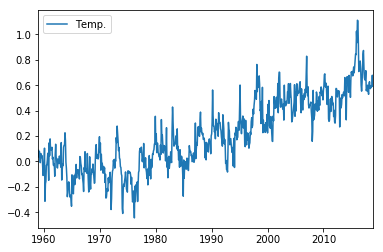

In [150]:
monthly.plot()

## Frequency analysis

In [183]:
x = np.arange(1959,2019,1./12)
y = monthly.values.squeeze()

In [184]:
freqs, X = signal.welch(y)

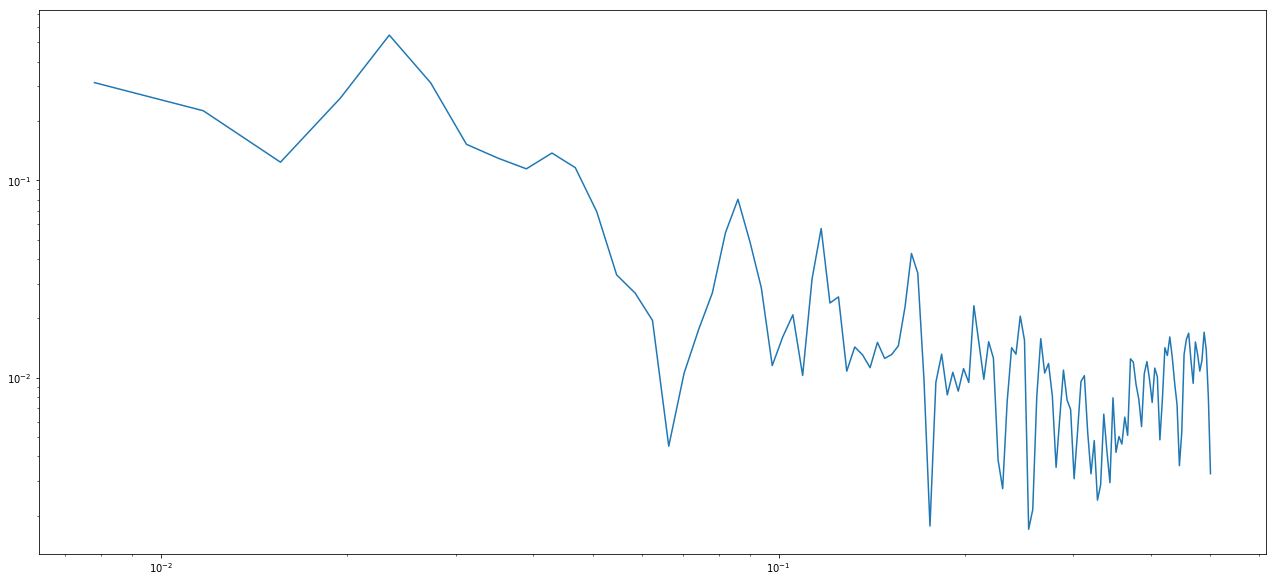

In [197]:
plt.figure(figsize=(22,10))

plt.loglog(freqs[2:], X[2:])

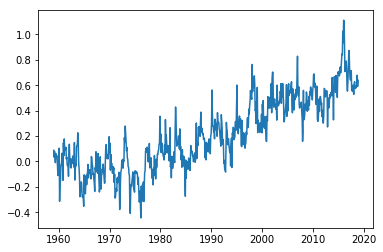

In [189]:
plt.plot(x, y)

(0.0001, 100.0)

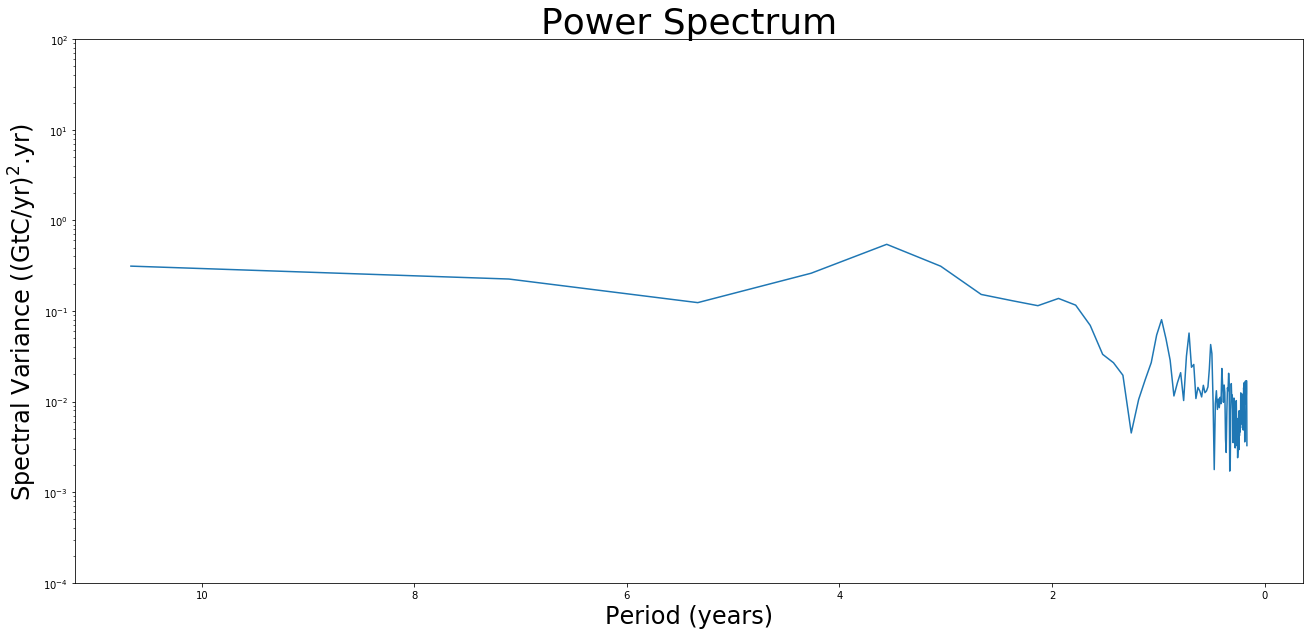

In [202]:
plt.figure(figsize=(22,10))

plt.semilogy(1/freqs[2:]/12, X[2:])

plt.title("Power Spectrum", fontsize=36)
plt.gca().invert_xaxis()
plt.xlabel("Period (years)", fontsize=24)
plt.ylabel("Spectral Variance ((GtC/yr)$^2$.yr)", fontsize=24)
plt.ylim([10e-5, 10e1])

# Annual

In [96]:
annual = pd.read_csv("./../co2_temp_data/temp/HADCRUT4_annual.txt",
            delim_whitespace=True,
            header=None,
            index_col=0,
            usecols=([0,13])
           )
annual.head()

,13
0,
1959,0.017
1960,-0.049
1961,0.038
1962,0.014
1963,0.048


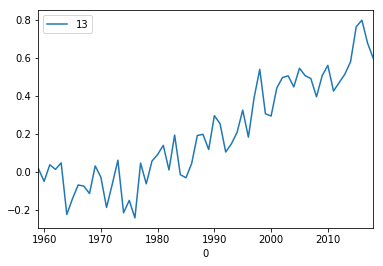

In [97]:
annual.plot()